## NPY file generator for Counting number of dwellings task

In [1]:
# import necessary pacakges

import rasterio 
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure
import matplotlib.patches as mpatches

In [2]:
#function to plot
def visualize_data(image,label):
    f, axarr = plt.subplots(1,2)
    image = image[:, :, 0:3]
    _ = image[:, :, 0].copy()
    image[:, :, 0] = image[:, :, 2]
    image[:, :, 2] = _
    image = image.astype(np.float64)
    for i in range(image.shape[2]):
        p2, p98 = np.percentile(image[:, :, i], (2, 98))
        image[:, :, i] = exposure.rescale_intensity(image[:, :, i],
                                                      in_range=(p2, p98))
    axarr[0].imshow(image)
    axarr[0].set_title("Satellite image")

    a=axarr[1]
    values = np.unique(label.ravel())
    im = axarr[1].imshow(label[:,:,0])
    a.set_title("Labeled image")
    colors = [im.cmap(im.norm(value)) for value in values] 
    label = ["No Dwellings","Dwelling Points"]
    patches = [mpatches.Patch(color=colors[i], label=j) for i, j in zip(range(len(values)), label)]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

### Loading the necessary dataset

In [3]:
# used dataset
image = rasterio.open("./used_data/CountImageLR.tif").read()
label = rasterio.open("./used_data/CountLabel.tif").read()
print(f"Shape of Main Image is {image.shape}")
print(f"Shape of Main Label is {label.shape}")

Shape of Main Image is (3, 2154, 2625)
Shape of Main Label is (1, 2154, 2625)


### Image Patching

Instead of random patching, here we are creating patches from entire dataset as we lack enough dataset.

In [4]:
PATCHSIZE = 128

def gridwise_sample(imgarray, patchsize):
    ''' to make a grid of 256x256 on top of the image and create sample patches '''
    nbands,nrows, ncols = imgarray.shape
    patchsamples = np.zeros(shape=(0, nbands,patchsize, patchsize),
                            dtype=imgarray.dtype)
    
    for i in range(int(nrows/patchsize)):
        for j in range(int(ncols/patchsize)):
            tocat = imgarray[:,i*patchsize:(i+1)*patchsize,
                             j*patchsize:(j+1)*patchsize]
            tocat = np.expand_dims(tocat, axis=0)
            patchsamples = np.concatenate((patchsamples, tocat),
                                          axis=0)
    return patchsamples

In [5]:
Xdata = gridwise_sample(image, PATCHSIZE)
Ydata = gridwise_sample(label, PATCHSIZE)
print(f"Shape of Xdata is {Xdata.shape}")
print(f"Shape of Ydata is {Ydata.shape}")

Shape of Xdata is (320, 3, 128, 128)
Shape of Ydata is (320, 1, 128, 128)


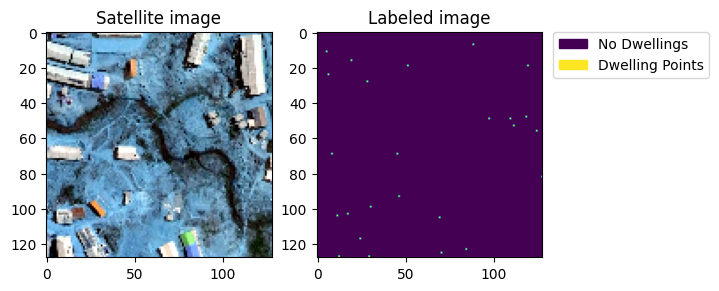

In [6]:
visualize_data(np.swapaxes(Xdata[240,:,:,:],0,2), np.swapaxes(Ydata[240,:,:,:],0,2))

### Normalize image and Remove nan values

In [7]:
# normalize inbetween 0-1
def image_norm(img):
    a = img.max()
    b = img.min()
    norm= (img-b)/(a-b)
    return norm

In [8]:
# remove nan
img = []
lab = []
Xdata = image_norm(Xdata)
for i in range(len(Xdata)):
    a = Xdata[i,:,:,:]
    b = Ydata[i,:,:,:]
    if np.isnan(a.any()):
        np.delete(a)
        np.delete(b)
    elif np.isnan(b.any()):
        np.delete(a)
        np.delete(b)
    else:
        img.append(a)
        lab.append(b)
total_img = np.asarray(img)
total_lab = np.asarray(lab)
print(f"shape of image is{total_img.shape}")
print(f"shape of image is{total_lab.shape}")

shape of image is(320, 3, 128, 128)
shape of image is(320, 1, 128, 128)


In [9]:
# checking max and min
print(f"max of img:{total_img.max()}")
print(f"min of img:{total_img.min()}")
print(f"max of lab:{total_lab.max()}")
print(f"min of lab:{total_lab.min()}")

max of img:1.0
min of img:0.0
max of lab:1
min of lab:0


### saving and loading as npy after preprocessing

In [12]:
np.save('/home/jovyan/private/CountDwellings/data_loader/used_data/Xdata_128CD.npy', total_img) # save
np.save('/home/jovyan/private/CountDwellings/data_loader/used_data/Ydata_128CD.npy', total_lab) # save

In [13]:
# loading in case needed
Xmain = np.load('/home/jovyan/private/CountDwellings/data_loader/used_data/Xdata_128CD.npy')
Ymain = np.load('/home/jovyan/private/CountDwellings/data_loader/used_data/Ydata_128CD.npy')# load
Xmain.shape, Ymain.shape

((320, 3, 128, 128), (320, 1, 128, 128))

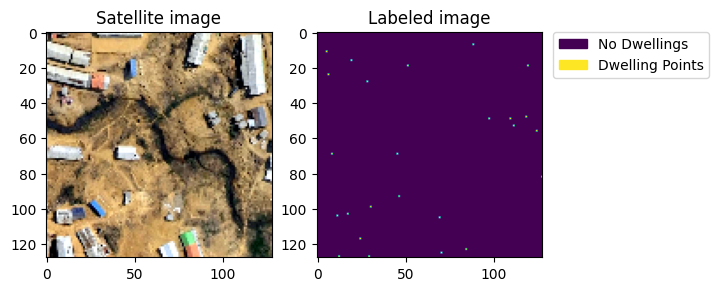

In [14]:
visualize_data(np.swapaxes(Xdata[240,:,:,:],0,2), np.swapaxes(Ydata[240,:,:,:],0,2))